# Chapter 17 – Autoencoders, GANs, and Diffusion Models

This notebook contains all the sample code and solutions to the exercises in chapter 17.

## Setup
This project requires Python 3.7 or above:

In [4]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [5]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Warning: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the TF_USE_LEGACY_KERAS environment variable to "1" and import the tf_keras package. This ensures that tf.keras points to tf_keras, which is Keras 2.*.

In [6]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" 

#import tf_keras

And TensorFlow ≥ 2.8:

In [7]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the ```images/generative``` folder (if it doesn't already exist), and define the ```save_fig()``` function which is used through this notebook to save the figures in high-res for the book:

In [9]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [10]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

## Performing PCA with an Undercomplete Linear Autoencoder
Let's build the Autoencoder...

In [11]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset as we used in Chapter 8:

In [12]:
# extra code – builds the same 3D dataset as in Chapter 8

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [13]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


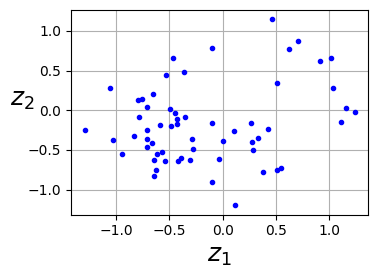

In [14]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders
### Implementing a Stacked Autoencoder Using Keras
Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [15]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [16]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0249 - val_loss: 0.0192
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0159 - val_loss: 0.0162
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0139
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 10/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.013

## Visualizing the Reconstructions
This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

1/1 [==============================] - 0s 39ms/step


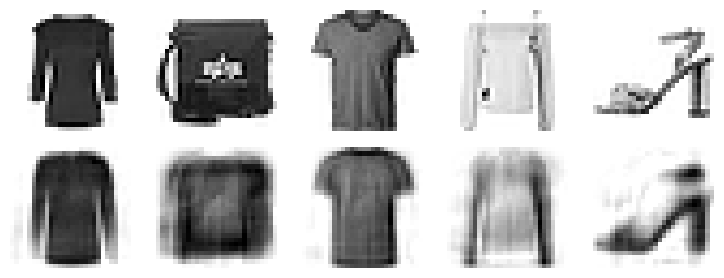

In [17]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [18]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 475us/step


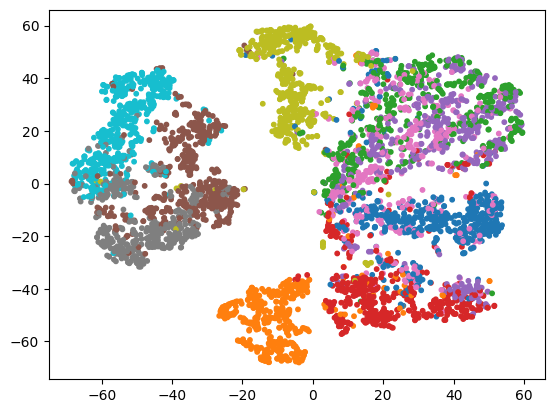

In [19]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from this Scikit-Learn example):

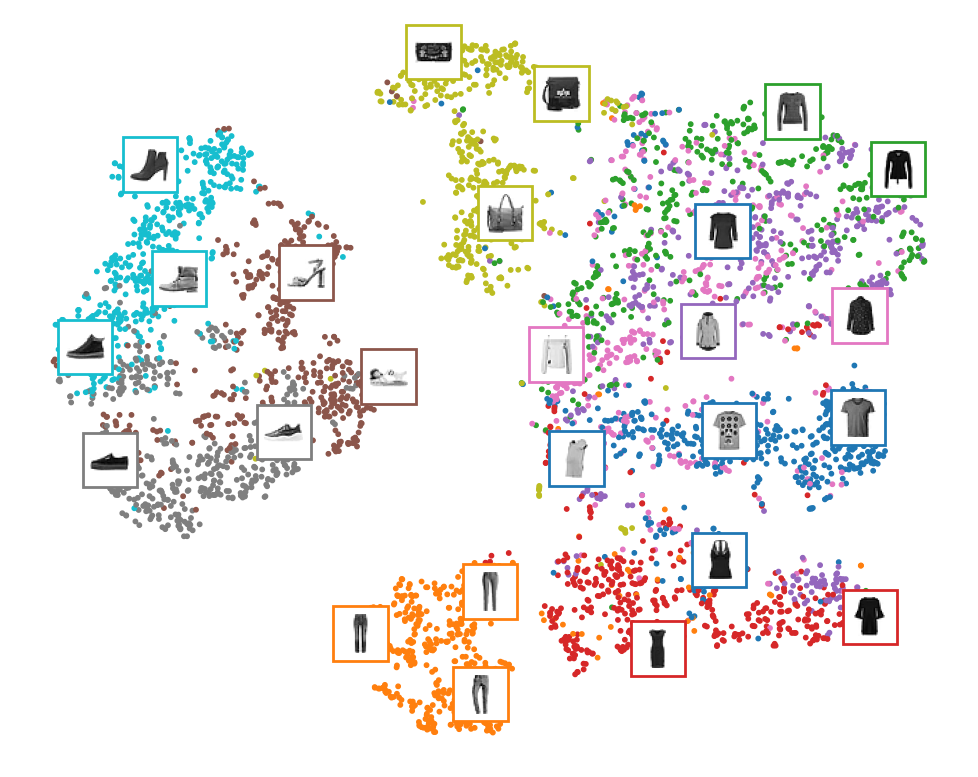

In [20]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights
It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [21]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [22]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# extra code – compiles and fits the model
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0242 - val_loss: 0.0177
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0166 - val_loss: 0.0157
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 9/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 10/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.012

1/1 [==============================] - 0s 36ms/step


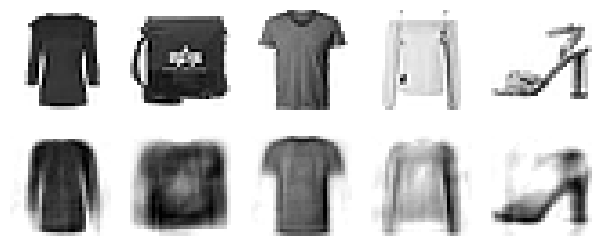

In [23]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()


## Extra Material – Training one Autoencoder at a Time

In [24]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [25]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0204 - val_loss: 0.0136
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 8/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 9/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 10/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.008

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [26]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 45ms/step


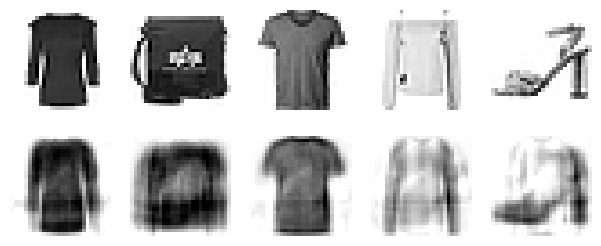

In [27]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

If needed, we can then continue training the full stacked autoencoder for a few epochs:

In [28]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 4/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0127 - val_loss: 0.0126


1/1 [==============================] - 0s 37ms/step


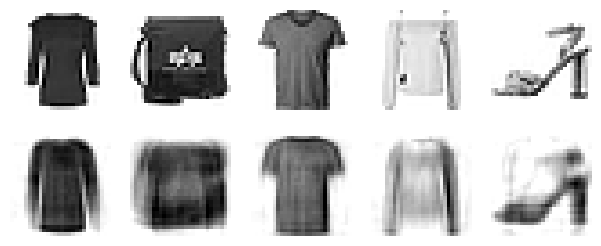

In [29]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders
Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [30]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 5ms/step - loss: 0.0324 - val_loss: 0.0249
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0202 - val_loss: 0.0199
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 8/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 9/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 10/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0

1/1 [==============================] - 0s 236ms/step


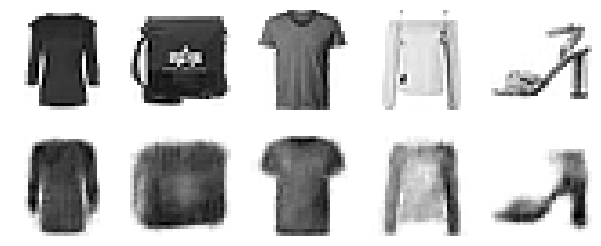

In [31]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

## Extra Material – Recurrent Autoencoders
Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [32]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

In [33]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 22s 10ms/step - loss: 0.0290 - val_loss: 0.0221
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0188 - val_loss: 0.0173
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0143 - val_loss: 0.0135
Epoch 5/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 8/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 9/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 10/10
1719/1719 [==============================] - 18s 10ms/s